In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'scale',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_scale_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 828)
(631390, 1)
validation
(74368, 828)
(74368, 1)
test
(85358, 828)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:25 - loss: 0.0224 - STD: 4.3730e-05 - MAE: 0.1006

 4/64 [>.............................] - ETA: 1s - loss: 0.0166 - STD: 3.8991e-04 - MAE: 0.0946  

 5/64 [=>............................] - ETA: 2s - loss: 0.0161 - STD: 4.9079e-04 - MAE: 0.0878

 6/64 [=>............................] - ETA: 2s - loss: 0.0159 - STD: 6.0003e-04 - MAE: 0.0836

 7/64 [==>...........................] - ETA: 3s - loss: 0.0155 - STD: 7.2914e-04 - MAE: 0.0803

 8/64 [==>...........................] - ETA: 3s - loss: 0.0151 - STD: 8.7865e-04 - MAE: 0.0791

 9/64 [===>..........................] - ETA: 3s - loss: 0.0149 - STD: 0.0010 - MAE: 0.0799    

10/64 [===>..........................] - ETA: 3s - loss: 0.0147 - STD: 0.0012 - MAE: 0.0809

11/64 [====>.........................] - ETA: 3s - loss: 0.0145 - STD: 0.0014 - MAE: 0.0809

12/64 [====>.........................] - ETA: 3s - loss: 0.0143 - STD: 0.0015 - MAE: 0.0798

13/64 [=====>........................] - ETA: 3s - loss: 0.0142 - STD: 0.0017 - MAE: 0.0784

14/64 [=====>........................] - ETA: 3s - loss: 0.0141 - STD: 0.0018 - MAE: 0.0770

15/64 [======>.......................] - ETA: 3s - loss: 0.0139 - STD: 0.0020 - MAE: 0.0757

16/64 [======>.......................] - ETA: 3s - loss: 0.0138 - STD: 0.0022 - MAE: 0.0749

17/64 [======>.......................] - ETA: 3s - loss: 0.0137 - STD: 0.0024 - MAE: 0.0746

18/64 [=======>......................] - ETA: 3s - loss: 0.0136 - STD: 0.0026 - MAE: 0.0747

19/64 [=======>......................] - ETA: 3s - loss: 0.0135 - STD: 0.0029 - MAE: 0.0749

20/64 [========>.....................] - ETA: 3s - loss: 0.0135 - STD: 0.0032 - MAE: 0.0750

21/64 [========>.....................] - ETA: 3s - loss: 0.0133 - STD: 0.0035 - MAE: 0.0745

22/64 [=========>....................] - ETA: 2s - loss: 0.0132 - STD: 0.0038 - MAE: 0.0740

23/64 [=========>....................] - ETA: 2s - loss: 0.0131 - STD: 0.0041 - MAE: 0.0733

24/64 [==========>...................] - ETA: 2s - loss: 0.0131 - STD: 0.0045 - MAE: 0.0726

25/64 [==========>...................] - ETA: 2s - loss: 0.0130 - STD: 0.0049 - MAE: 0.0720

26/64 [===========>..................] - ETA: 2s - loss: 0.0129 - STD: 0.0054 - MAE: 0.0717

27/64 [===========>..................] - ETA: 2s - loss: 0.0128 - STD: 0.0060 - MAE: 0.0715

28/64 [============>.................] - ETA: 2s - loss: 0.0126 - STD: 0.0066 - MAE: 0.0713

29/64 [============>.................] - ETA: 2s - loss: 0.0125 - STD: 0.0074 - MAE: 0.0711

30/64 [=============>................] - ETA: 2s - loss: 0.0124 - STD: 0.0082 - MAE: 0.0706

31/64 [=============>................] - ETA: 2s - loss: 0.0123 - STD: 0.0091 - MAE: 0.0699

32/64 [==============>...............] - ETA: 2s - loss: 0.0121 - STD: 0.0102 - MAE: 0.0693

33/64 [==============>...............] - ETA: 2s - loss: 0.0120 - STD: 0.0113 - MAE: 0.0687

34/64 [==============>...............] - ETA: 2s - loss: 0.0118 - STD: 0.0127 - MAE: 0.0682

35/64 [===============>..............] - ETA: 2s - loss: 0.0117 - STD: 0.0142 - MAE: 0.0677

36/64 [===============>..............] - ETA: 2s - loss: 0.0115 - STD: 0.0159 - MAE: 0.0672

37/64 [================>.............] - ETA: 1s - loss: 0.0113 - STD: 0.0176 - MAE: 0.0668

38/64 [================>.............] - ETA: 1s - loss: 0.0112 - STD: 0.0194 - MAE: 0.0664

39/64 [=================>............] - ETA: 2s - loss: 0.0112 - STD: 0.0211 - MAE: 0.0660

43/64 [===================>..........] - ETA: 1s - loss: 0.0106 - STD: 0.0282 - MAE: 0.0644

44/64 [===================>..........] - ETA: 1s - loss: 0.0104 - STD: 0.0295 - MAE: 0.0639

45/64 [====================>.........] - ETA: 1s - loss: 0.0103 - STD: 0.0307 - MAE: 0.0635

46/64 [====================>.........] - ETA: 1s - loss: 0.0102 - STD: 0.0318 - MAE: 0.0630

47/64 [=====================>........] - ETA: 1s - loss: 0.0101 - STD: 0.0328 - MAE: 0.0626

48/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 0.0337 - MAE: 0.0621

49/64 [=====================>........] - ETA: 1s - loss: 0.0098 - STD: 0.0346 - MAE: 0.0617

50/64 [======================>.......] - ETA: 1s - loss: 0.0097 - STD: 0.0356 - MAE: 0.0613

51/64 [======================>.......] - ETA: 1s - loss: 0.0096 - STD: 0.0366 - MAE: 0.0608

52/64 [=======================>......] - ETA: 0s - loss: 0.0095 - STD: 0.0377 - MAE: 0.0604

53/64 [=======================>......] - ETA: 0s - loss: 0.0094 - STD: 0.0389 - MAE: 0.0600

54/64 [========================>.....] - ETA: 0s - loss: 0.0093 - STD: 0.0401 - MAE: 0.0597

55/64 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 0.0412 - MAE: 0.0593

56/64 [=========================>....] - ETA: 0s - loss: 0.0091 - STD: 0.0422 - MAE: 0.0590

57/64 [=========================>....] - ETA: 0s - loss: 0.0090 - STD: 0.0432 - MAE: 0.0586

58/64 [==========================>...] - ETA: 0s - loss: 0.0089 - STD: 0.0441 - MAE: 0.0582

59/64 [==========================>...] - ETA: 0s - loss: 0.0088 - STD: 0.0450 - MAE: 0.0579

60/64 [===========================>..] - ETA: 0s - loss: 0.0087 - STD: 0.0458 - MAE: 0.0576

61/64 [===========================>..] - ETA: 0s - loss: 0.0086 - STD: 0.0464 - MAE: 0.0572

62/64 [============================>.] - ETA: 0s - loss: 0.0085 - STD: 0.0471 - MAE: 0.0569

63/64 [============================>.] - ETA: 0s - loss: 0.0084 - STD: 0.0478 - MAE: 0.0566

64/64 [==============================] - ETA: 0s - loss: 0.0083 - STD: 0.0486 - MAE: 0.0562

64/64 [==============================] - 7s 89ms/step - loss: 0.0083 - STD: 0.0486 - MAE: 0.0562 - val_loss: 0.0047 - val_STD: 0.0747 - val_MAE: 0.0427


Epoch 2/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.1003 - MAE: 0.0361

 2/64 [..............................] - ETA: 5s - loss: 0.0033 - STD: 0.0996 - MAE: 0.0365

 3/64 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0989 - MAE: 0.0367

 4/64 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0987 - MAE: 0.0365

 5/64 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0991 - MAE: 0.0365

 6/64 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0993 - MAE: 0.0364

 7/64 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0984 - MAE: 0.0362

 8/64 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0978 - MAE: 0.0361

 9/64 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0976 - MAE: 0.0361

10/64 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0976 - MAE: 0.0360

11/64 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0979 - MAE: 0.0359

12/64 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0982 - MAE: 0.0358

14/64 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0985 - MAE: 0.0358

15/64 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0989 - MAE: 0.0358

16/64 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0988 - MAE: 0.0357

17/64 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0985 - MAE: 0.0357

18/64 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0984 - MAE: 0.0357

19/64 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0982 - MAE: 0.0356

20/64 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0982 - MAE: 0.0356

21/64 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0983 - MAE: 0.0355

22/64 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0984 - MAE: 0.0355

23/64 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0984 - MAE: 0.0354

24/64 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0986 - MAE: 0.0354

25/64 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0986 - MAE: 0.0353

26/64 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0986 - MAE: 0.0353

27/64 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0986 - MAE: 0.0353

28/64 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0986 - MAE: 0.0352

29/64 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0987 - MAE: 0.0352

30/64 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0986 - MAE: 0.0351

31/64 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0986 - MAE: 0.0351

32/64 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0987 - MAE: 0.0350

33/64 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0988 - MAE: 0.0350

34/64 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0988 - MAE: 0.0349

35/64 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0349

36/64 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0348

37/64 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0348

38/64 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0348

39/64 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0347

40/64 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0347

41/64 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0990 - MAE: 0.0347

42/64 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0991 - MAE: 0.0346

43/64 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0992 - MAE: 0.0346

44/64 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0993 - MAE: 0.0345

45/64 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0993 - MAE: 0.0345

46/64 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0993 - MAE: 0.0345

47/64 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0994 - MAE: 0.0344

48/64 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0994 - MAE: 0.0344

49/64 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0994 - MAE: 0.0343

50/64 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0995 - MAE: 0.0343

51/64 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0995 - MAE: 0.0342

52/64 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0995 - MAE: 0.0342

53/64 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0996 - MAE: 0.0342

54/64 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0997 - MAE: 0.0341

55/64 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0997 - MAE: 0.0341

56/64 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0997 - MAE: 0.0341

57/64 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0997 - MAE: 0.0340

58/64 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0997 - MAE: 0.0340

59/64 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0998 - MAE: 0.0340

60/64 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0998 - MAE: 0.0339

61/64 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0998 - MAE: 0.0339

62/64 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0999 - MAE: 0.0338

63/64 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0999 - MAE: 0.0338

64/64 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.0999 - MAE: 0.0337

64/64 [==============================] - 5s 78ms/step - loss: 0.0026 - STD: 0.0999 - MAE: 0.0337 - val_loss: 0.0027 - val_STD: 0.0839 - val_MAE: 0.0352


Epoch 3/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0021 - STD: 0.1025 - MAE: 0.0312

 2/64 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.1009 - MAE: 0.0314

 3/64 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.1007 - MAE: 0.0312

 4/64 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.1017 - MAE: 0.0312

 5/64 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.1011 - MAE: 0.0311

 6/64 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.1012 - MAE: 0.0312

 7/64 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.1016 - MAE: 0.0311

 8/64 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.1016 - MAE: 0.0309

 9/64 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.1014 - MAE: 0.0309

10/64 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.1015 - MAE: 0.0309

11/64 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.1020 - MAE: 0.0309

12/64 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.1016 - MAE: 0.0309

13/64 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.1018 - MAE: 0.0308

14/64 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.1018 - MAE: 0.0308

15/64 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1017 - MAE: 0.0308

16/64 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1018 - MAE: 0.0307

17/64 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1021 - MAE: 0.0307

18/64 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1021 - MAE: 0.0307

19/64 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0307

20/64 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0306

21/64 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0306

22/64 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.1024 - MAE: 0.0306

23/64 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0305

24/64 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1024 - MAE: 0.0305

25/64 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1024 - MAE: 0.0305

26/64 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0304

27/64 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0304

28/64 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1024 - MAE: 0.0304

29/64 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1027 - MAE: 0.0304

30/64 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0303

31/64 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0303

32/64 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0303

33/64 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0303

34/64 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0303

35/64 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.1027 - MAE: 0.0303

36/64 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0303

37/64 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0303

38/64 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0303

39/64 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0303

40/64 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0304

41/64 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0304

42/64 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0304

43/64 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1027 - MAE: 0.0304

44/64 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0304

45/64 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0304

46/64 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0304

47/64 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0304

48/64 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0304

49/64 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0304

50/64 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0304

51/64 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0303

52/64 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0303

53/64 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0303

54/64 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0303

55/64 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0302

56/64 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0302

57/64 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0302

58/64 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0302

59/64 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0302

60/64 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0302

61/64 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0301

62/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0301

63/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0301

64/64 [==============================] - 5s 79ms/step - loss: 0.0019 - STD: 0.1030 - MAE: 0.0301 - val_loss: 0.0022 - val_STD: 0.0939 - val_MAE: 0.0314


Epoch 4/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0286

 2/64 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1072 - MAE: 0.0287

 3/64 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0288

 5/64 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1066 - MAE: 0.0286

 6/64 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0286

 7/64 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0286

 8/64 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0285

 9/64 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0285

10/64 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0285

11/64 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0286

12/64 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0285

13/64 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0286

14/64 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0286

15/64 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0286

16/64 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0286

17/64 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0286

18/64 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0286

19/64 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0287

20/64 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0287

21/64 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0286

22/64 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0286

23/64 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0286

24/64 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0286

25/64 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0286

26/64 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0286

27/64 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0286

28/64 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0285

29/64 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0285

30/64 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0285

31/64 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0285

32/64 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0285

33/64 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0285

34/64 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0285

35/64 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0285

36/64 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0285

37/64 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0285

38/64 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0285

39/64 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0285

40/64 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0285

41/64 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0285

42/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0285

43/64 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0285

44/64 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0286

45/64 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0286

46/64 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0286

47/64 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0286

48/64 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0286

49/64 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0286

50/64 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0286

51/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0286

52/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0286

53/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0286

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0286

55/64 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0286

56/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0286

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0286

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0286

59/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0286

60/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0285

61/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0285

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0286

63/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0286

64/64 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0286

64/64 [==============================] - 5s 79ms/step - loss: 0.0017 - STD: 0.1046 - MAE: 0.0286 - val_loss: 0.0024 - val_STD: 0.0976 - val_MAE: 0.0333


Epoch 5/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.1098 - MAE: 0.0292

 2/64 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0297

 3/64 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0292

 4/64 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1062 - MAE: 0.0292

 5/64 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0298

 6/64 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0295

 7/64 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0295

 8/64 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0297

 9/64 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0296

10/64 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0295

11/64 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0294

12/64 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0293

13/64 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0292

14/64 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0293

15/64 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0292

16/64 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0292

17/64 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0293

18/64 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0292

19/64 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0292

20/64 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0292

21/64 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0292

22/64 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0292

23/64 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0292

24/64 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0291

25/64 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0291

26/64 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0290

27/64 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0290

28/64 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0290

29/64 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0289

30/64 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0290

31/64 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0289

32/64 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0289

33/64 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0288

34/64 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0288

35/64 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0288

36/64 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0288

37/64 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0288

38/64 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0287

39/64 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0287

40/64 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0287

41/64 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0287

42/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0287

43/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0286

44/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0286

45/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0286

46/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0286

47/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0285

48/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0285

49/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0285

50/64 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0285

51/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0285

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0284

53/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0284

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0284

55/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0284

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0284

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0284

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0283

59/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0283

60/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0283

61/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0283

63/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0283

64/64 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0283

64/64 [==============================] - 5s 80ms/step - loss: 0.0017 - STD: 0.1048 - MAE: 0.0283 - val_loss: 0.0018 - val_STD: 0.0937 - val_MAE: 0.0291


Epoch 6/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0278

 2/64 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0274

 3/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0272

 4/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0274

 5/64 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0274

 6/64 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0274

 7/64 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0274

 8/64 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0274

 9/64 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0275

10/64 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0275

11/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0275

12/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0274

13/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

14/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0275

15/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0274

16/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0274

17/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0275

18/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

19/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0275

20/64 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

21/64 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

22/64 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

23/64 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

24/64 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0276

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0277

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0277

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0277

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0277

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0277

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

33/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

34/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

35/64 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

36/64 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

37/64 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0275

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

49/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

50/64 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0276

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

64/64 [==============================] - 5s 78ms/step - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276 - val_loss: 0.0017 - val_STD: 0.0898 - val_MAE: 0.0292


Epoch 7/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.0983 - MAE: 0.0297

 2/64 [..............................] - ETA: 6s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0287

 3/64 [>.............................] - ETA: 5s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0282

 4/64 [>.............................] - ETA: 5s - loss: 0.0017 - STD: 0.1025 - MAE: 0.0288

 5/64 [=>............................] - ETA: 5s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0287

 6/64 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0284

 7/64 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0284

 8/64 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0284

 9/64 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0283

10/64 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0282

11/64 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0283

12/64 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0284

13/64 [=====>........................] - ETA: 4s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0283

14/64 [=====>........................] - ETA: 4s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0283

15/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0283

16/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0282

17/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0282

18/64 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0283

19/64 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0282

20/64 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0281

21/64 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0281

22/64 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0280

23/64 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0280

24/64 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0280

26/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0280

27/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0280

28/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0280

29/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0280

30/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0280

31/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0280

32/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0279

33/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0280

34/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0279

35/64 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0279

36/64 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0279

37/64 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0278

38/64 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0278

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0278

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0278

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0278

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0278

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0277

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

49/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

50/64 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

64/64 [==============================] - 5s 81ms/step - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275 - val_loss: 0.0020 - val_STD: 0.0972 - val_MAE: 0.0303


Epoch 8/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0016 - STD: 0.1083 - MAE: 0.0270

 2/64 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1072 - MAE: 0.0270

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0267

 4/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0269

 5/64 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0268

 6/64 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

 7/64 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

 8/64 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

 9/64 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

10/64 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

11/64 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0271

12/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

13/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0274

14/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0273

15/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0274

16/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0274

17/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0274

18/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0274

19/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0274

20/64 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0274

21/64 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0273

22/64 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0273

23/64 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0273

24/64 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0273

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0273

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0272

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0272

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

33/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

34/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

35/64 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

36/64 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

37/64 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0274

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0274

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0274

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0274

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0274

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0274

49/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0274

50/64 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0274

51/64 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0274

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0274

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0275

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0275

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0275

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0275

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0275

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0276

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0276

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0276

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0276

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0276

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0276

64/64 [==============================] - 5s 79ms/step - loss: 0.0016 - STD: 0.1053 - MAE: 0.0276 - val_loss: 0.0020 - val_STD: 0.0976 - val_MAE: 0.0308


Epoch 9/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1081 - MAE: 0.0270

 2/64 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1090 - MAE: 0.0268

 3/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0277

 4/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1068 - MAE: 0.0278

 5/64 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1060 - MAE: 0.0275

 6/64 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0277

 7/64 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0278

 8/64 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0278

 9/64 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0278

10/64 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1066 - MAE: 0.0280

11/64 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0280

12/64 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0279

13/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0280

14/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0280

15/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0279

16/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0280

17/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0281

18/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0280

19/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0281

20/64 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0281

21/64 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0280

22/64 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0281

23/64 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0281

24/64 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0281

25/64 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0281

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0281

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0281

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0281

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0281

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0281

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0281

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0280

33/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0280

34/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0280

35/64 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0280

36/64 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0280

37/64 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0280

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0279

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0279

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0279

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0279

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0279

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0279

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0279

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0279

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0278

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0278

49/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0278

50/64 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0278

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0278

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0278

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0277

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0277

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0276

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0276

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0276

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

64/64 [==============================] - 5s 79ms/step - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276 - val_loss: 0.0018 - val_STD: 0.0967 - val_MAE: 0.0293


Epoch 10/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0269

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0268

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

 4/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

 5/64 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

 6/64 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

 7/64 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

 8/64 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

 9/64 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0265

10/64 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0264

11/64 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

12/64 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0267

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

19/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

20/64 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

22/64 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

23/64 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

24/64 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

34/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

35/64 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

36/64 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

37/64 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

49/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

50/64 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

64/64 [==============================] - 5s 79ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267 - val_loss: 0.0019 - val_STD: 0.0985 - val_MAE: 0.0295


Epoch 11/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0264

 2/64 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0267

 3/64 [>.............................] - ETA: 5s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

 4/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

 5/64 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0266

 6/64 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0265

 7/64 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0267

 8/64 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

 9/64 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

10/64 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

11/64 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0268

12/64 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0268

13/64 [=====>........................] - ETA: 4s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0268

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0270

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0270

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0270

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0271

18/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0273

19/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0274

20/64 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0274

21/64 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0274

22/64 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0277

23/64 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0277

24/64 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0276

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0277

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0277

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0276

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0277

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0277

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0276

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0276

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0276

33/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0276

34/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0276

35/64 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0276

36/64 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0275

37/64 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0275

38/64 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0275

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0274

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0274

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0274

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0274

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0274

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0273

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

49/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

50/64 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0273

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0273

64/64 [==============================] - 5s 79ms/step - loss: 0.0016 - STD: 0.1055 - MAE: 0.0273 - val_loss: 0.0015 - val_STD: 0.0935 - val_MAE: 0.0279


Epoch 12/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0015 - STD: 0.1037 - MAE: 0.0272

 2/64 [..............................] - ETA: 5s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0275

 3/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0275

 4/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0271

 5/64 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

 6/64 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

 7/64 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0271

 8/64 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0272

 9/64 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

10/64 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0272

12/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0275

13/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0275

14/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0275

15/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0278

16/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

17/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0279

18/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0282

19/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0282

20/64 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0284

21/64 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0287

22/64 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0287

23/64 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0290

24/64 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0290

25/64 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0291

26/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0292

27/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0291

28/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0292

29/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0291

30/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0291

31/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0290

32/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0290

33/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0290

34/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0289

35/64 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0289

36/64 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0288

37/64 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0288

38/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0287

39/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0287

40/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0287

41/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0286

42/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0286

43/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0286

44/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0285

45/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0285

46/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0284

47/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0284

48/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0284

49/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0283

50/64 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0283

51/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0282

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0282

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0282

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0281

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0281

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0281

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0280

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0280

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0280

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0280

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0279

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0279

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0279

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0279

64/64 [==============================] - 5s 79ms/step - loss: 0.0016 - STD: 0.1051 - MAE: 0.0279 - val_loss: 0.0017 - val_STD: 0.0962 - val_MAE: 0.0289


Epoch 13/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1043 - MAE: 0.0261

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0261

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1038 - MAE: 0.0264

 4/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1035 - MAE: 0.0263

 5/64 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1040 - MAE: 0.0263

 6/64 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1042 - MAE: 0.0262

 7/64 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1043 - MAE: 0.0263

 8/64 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0263

 9/64 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0263

10/64 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0264

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0264

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0264

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0264

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0264

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0264

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0264

19/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0264

20/64 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

21/64 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

22/64 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

23/64 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

24/64 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

34/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

35/64 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

36/64 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

49/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

50/64 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

64/64 [==============================] - 5s 78ms/step - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265 - val_loss: 0.0015 - val_STD: 0.0937 - val_MAE: 0.0279


Epoch 14/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0015 - STD: 0.1013 - MAE: 0.0271

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1038 - MAE: 0.0268

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0270

 4/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0270

 5/64 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

 6/64 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

 7/64 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0269

 8/64 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0268

 9/64 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

10/64 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

19/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

20/64 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

21/64 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

22/64 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

23/64 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

24/64 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

34/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

35/64 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

36/64 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

37/64 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

49/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

50/64 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0266

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

64/64 [==============================] - 5s 78ms/step - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267 - val_loss: 0.0018 - val_STD: 0.0975 - val_MAE: 0.0297


Epoch 15/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0264

 3/64 [>.............................] - ETA: 5s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

 4/64 [>.............................] - ETA: 5s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

 5/64 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0268

 6/64 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0271

 7/64 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0270

 8/64 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1070 - MAE: 0.0270

 9/64 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0271

10/64 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0270

11/64 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1073 - MAE: 0.0272

12/64 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0273

14/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1072 - MAE: 0.0278

15/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1064 - MAE: 0.0284

16/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1063 - MAE: 0.0283

17/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1071 - MAE: 0.0289

18/64 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1065 - MAE: 0.0290

19/64 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1061 - MAE: 0.0291

20/64 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1064 - MAE: 0.0294

21/64 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1064 - MAE: 0.0292

22/64 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0294

23/64 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0292

24/64 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0293

25/64 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0292

26/64 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0293

27/64 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0292

28/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0292

29/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1054 - MAE: 0.0292

30/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0291

31/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0291

32/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1054 - MAE: 0.0290

33/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0290

34/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0289

35/64 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0289

36/64 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0289

37/64 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0288

38/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0288

39/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0287

40/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0287

41/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0287

42/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0286

43/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0286

44/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0285

45/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0285

46/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0285

47/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0284

48/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0284

49/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0283

50/64 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0283

51/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0283

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0282

53/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0282

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0282

55/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0281

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0281

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0281

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0281

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0280

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0280

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0280

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0280

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0279

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0279

64/64 [==============================] - 5s 79ms/step - loss: 0.0016 - STD: 0.1052 - MAE: 0.0279 - val_loss: 0.0017 - val_STD: 0.0961 - val_MAE: 0.0284


Epoch 16/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0259

 3/64 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1040 - MAE: 0.0262

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1044 - MAE: 0.0263

 5/64 [=>............................] - ETA: 3s - loss: 0.0014 - STD: 0.1042 - MAE: 0.0262

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1040 - MAE: 0.0263

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1044 - MAE: 0.0263

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0264

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0264

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

19/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

20/64 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

21/64 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

22/64 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

23/64 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

34/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

35/64 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

36/64 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

37/64 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

49/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

50/64 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

64/64 [==============================] - 5s 79ms/step - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264 - val_loss: 0.0019 - val_STD: 0.0980 - val_MAE: 0.0300


Epoch 17/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0270

 2/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0266

 4/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

 5/64 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

 6/64 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

 7/64 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

 8/64 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

 9/64 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

10/64 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

11/64 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

12/64 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

13/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0262

14/64 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0262

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

19/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

20/64 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

21/64 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

22/64 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

23/64 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

24/64 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0263

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

34/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

35/64 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

36/64 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

37/64 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

49/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

50/64 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0263

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0263

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0263

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0263

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0263

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0263

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0263

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0263

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

64/64 [==============================] - 5s 78ms/step - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263 - val_loss: 0.0017 - val_STD: 0.0972 - val_MAE: 0.0285


Epoch 18/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0259

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1071 - MAE: 0.0260

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0259

 4/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0259

 5/64 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0259

 6/64 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

 7/64 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

 8/64 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0260

 9/64 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

10/64 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

11/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0261

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0261

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

19/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

20/64 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

21/64 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

22/64 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

23/64 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

34/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

35/64 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

36/64 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

37/64 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

49/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

50/64 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0262

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0262

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0262

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0262

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0262

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0262

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

64/64 [==============================] - 5s 78ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261 - val_loss: 0.0016 - val_STD: 0.0961 - val_MAE: 0.0284


Epoch 19/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

 2/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

 3/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

 4/64 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0261

 5/64 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

 6/64 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

 7/64 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

 8/64 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

 9/64 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

10/64 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0262

11/64 [====>.........................] - ETA: 4s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

17/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

19/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

20/64 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

21/64 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

22/64 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

23/64 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

27/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

28/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

29/64 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

30/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

31/64 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

32/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

33/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

34/64 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

35/64 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

36/64 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

37/64 [================>.............] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

38/64 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0261

39/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0262

40/64 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0262

41/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0262

42/64 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0262

43/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0262

44/64 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0262

45/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

46/64 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0262

47/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

48/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0262

49/64 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0262

50/64 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0262

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0263

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0263

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0262

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0263

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0263

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

64/64 [==============================] - 5s 76ms/step - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262 - val_loss: 0.0016 - val_STD: 0.0957 - val_MAE: 0.0279


Epoch 20/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1047 - MAE: 0.0260

 2/64 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0260

 3/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0262

 4/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0262

 5/64 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

 6/64 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

 7/64 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

 8/64 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0262

 9/64 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0261

10/64 [===>..........................] - ETA: 4s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0261

11/64 [====>.........................] - ETA: 4s - loss: 0.0014 - STD: 0.1049 - MAE: 0.0262

12/64 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0262

13/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0261

14/64 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0262

15/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0262

16/64 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0261

18/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0262

19/64 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0262

20/64 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0262

21/64 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0262

22/64 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0262

23/64 [=========>....................] - ETA: 3s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0262

24/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0263

25/64 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0263

26/64 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0263

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0263

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

34/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

35/64 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

36/64 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

37/64 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

49/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

50/64 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0263

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0263

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0263

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

64/64 [==============================] - 5s 80ms/step - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263 - val_loss: 0.0015 - val_STD: 0.0955 - val_MAE: 0.0277


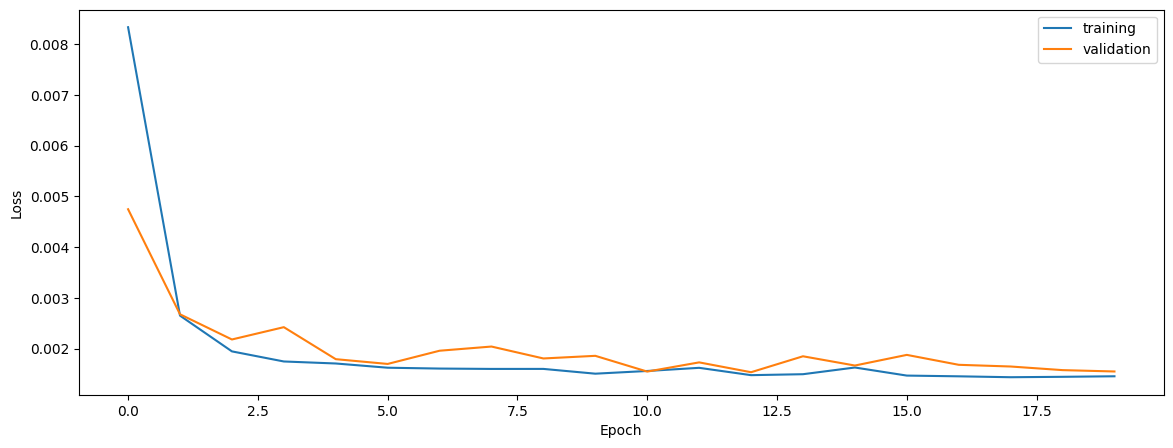

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9406812383116279
0.9534625045307423
0.9491064678187618


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.9406812383116279
0.9534625045307423
0.9491064678187618


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.9478209804770322
0.9564331639474566
0.9609875441600879


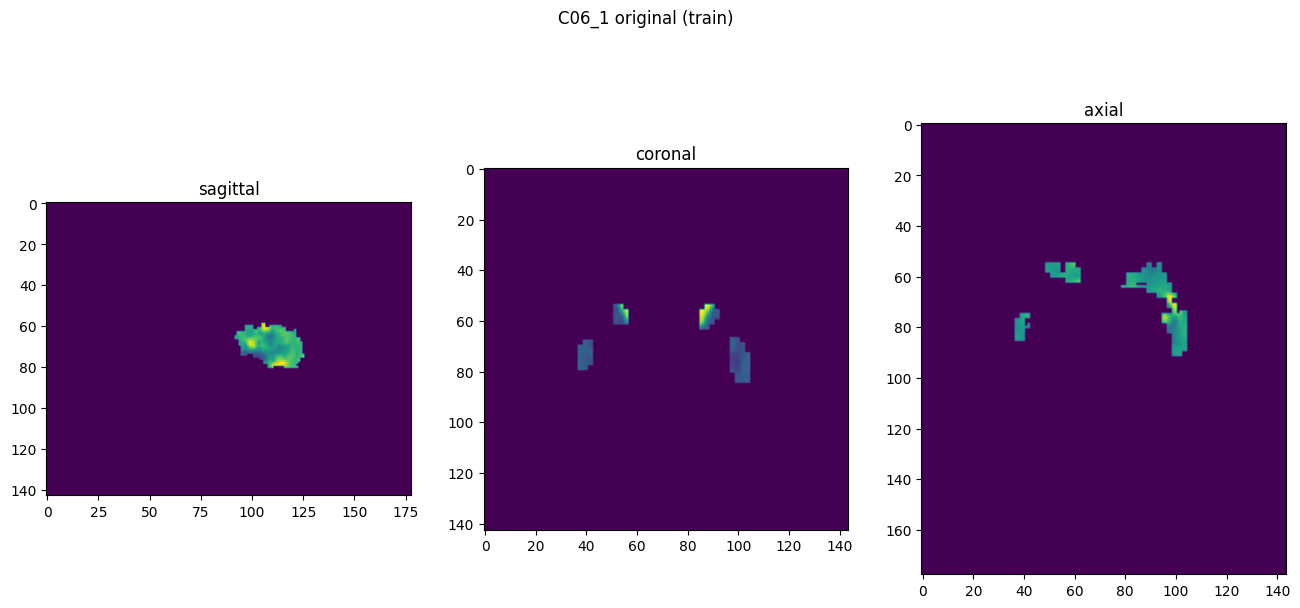

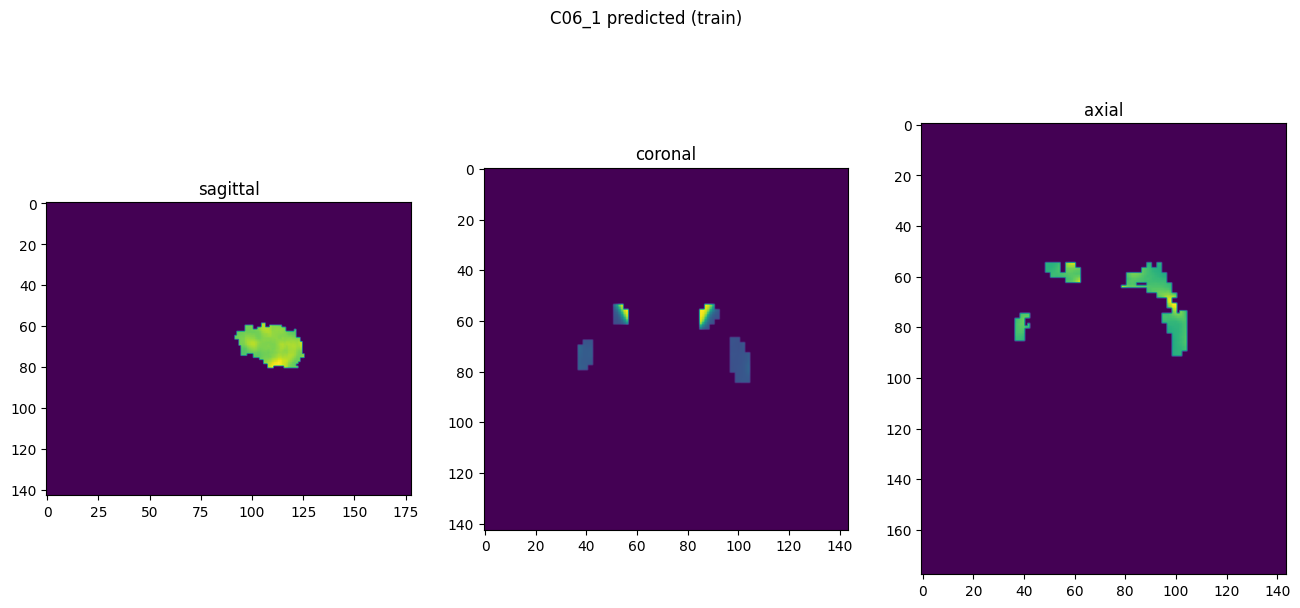

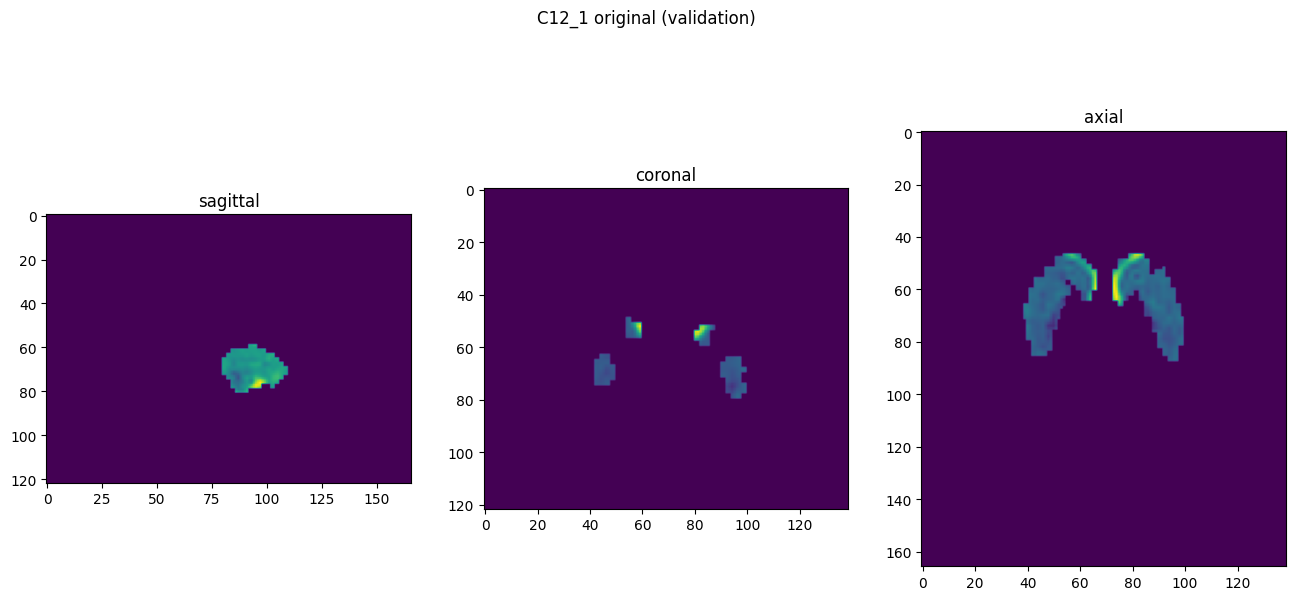

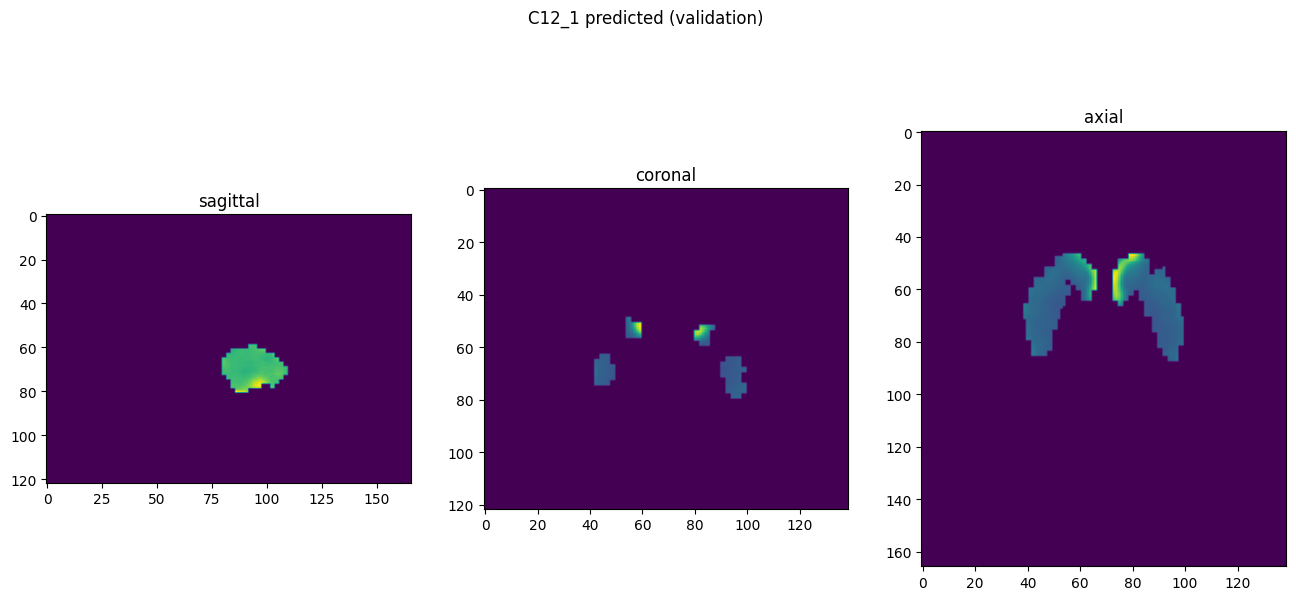

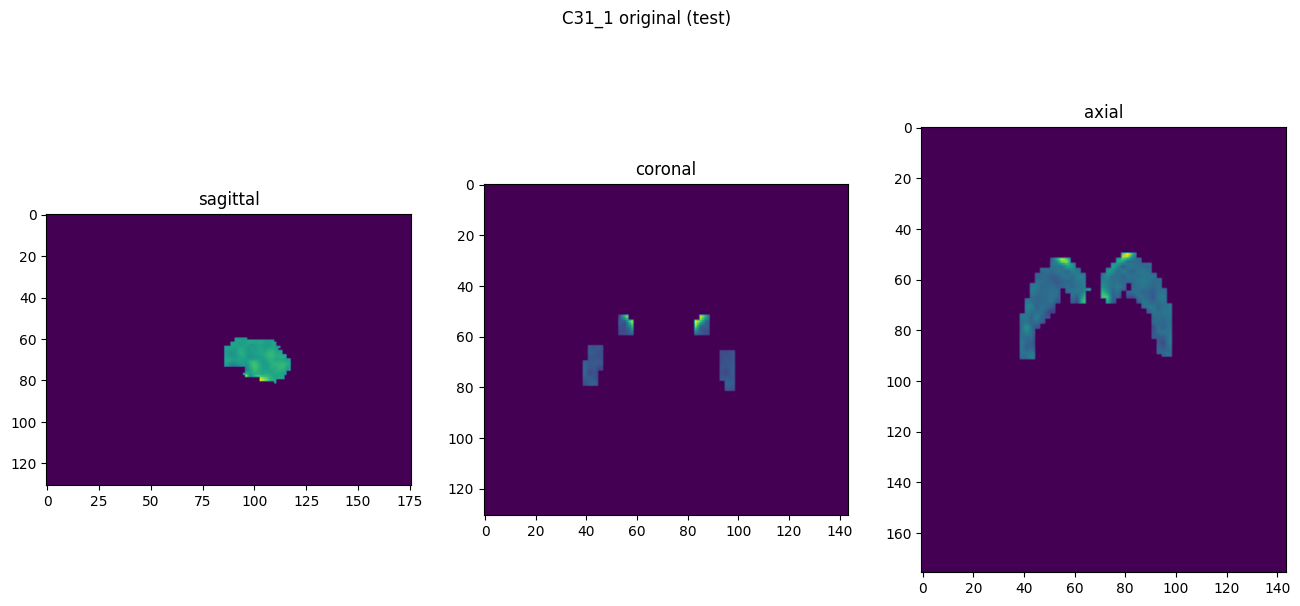

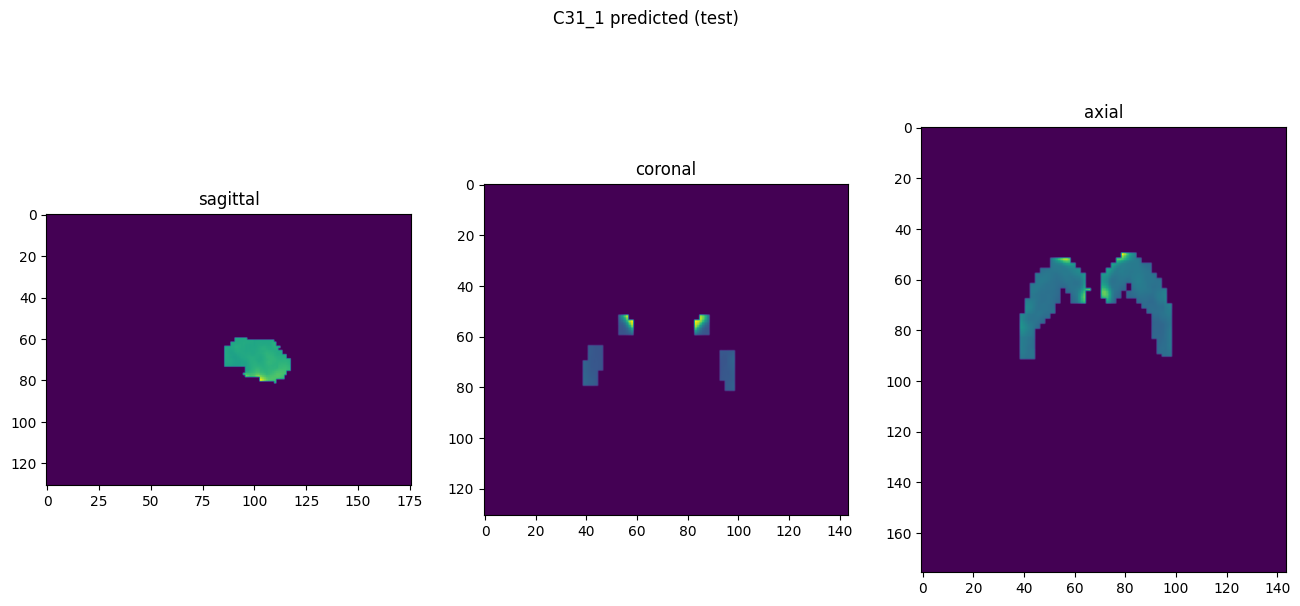

In [10]:
showResults(model, gen, threshold=None, background=False)